# Sales Orders Time Series Forecasting - ML Cohort WiD

_**Business Problem**: In the FMCG industry, food manufacturers work hard to reduce the likelihood of over and under supply production while meeting demand. With over production comes a risk of food waste and with under production, food shortage. Using data on historical sales orders, this timeseries modelling project aims to predict future sales orders in order to help food manufacturers plan and avoid loss of profits due to food shortage and food waste._

_**Data Source:** [Kaggle: Superstore orders, sales target data 2017 to 2020](https://www.kaggle.com/datasets/dommatap/superstore-orders-sales-target-data-2017-to-2020?resource=download)_

## Import Libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd
from math import sqrt

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# time
import datetime as dt
import time as time

# pipeline
from imblearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# models
from sklearn.ensemble import RandomForestRegressor

# optimization and hyperparameters
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# model evaluation
from sklearn.metrics import mean_squared_error

# model interpretability
# import shap
# shap.initjs()

# saving models
from joblib import dump

## Data Access

In [50]:
df = pd.read_csv('History_SellIn_SellOut.csv', sep=';')
df.head()

,PERIOD_TAG,product_group,customer_name,dispatches_SellIn,orders_SellIn,Sellout,numeric_distribution_selling_promotion,type_promo_1,type_promo_2
0,2016-08-07,Product_01,Customer_01,130,130,0.000000,0.0,0.0,0.0
1,2016-08-14,Product_01,Customer_01,4,5,102.274039,0.1,0.0,0.0
2,2016-08-21,Product_01,Customer_01,130,130,93.380644,0.0,0.0,0.0
3,2016-08-28,Product_01,Customer_01,61,61,101.162365,0.0,0.0,0.0
4,2016-09-04,Product_01,Customer_01,57,58,120.060829,0.1,0.0,0.0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6804 entries, 0 to 6803
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   PERIOD_TAG                              6804 non-null   object 
 1   product_group                           6804 non-null   object 
 2   customer_name                           6804 non-null   object 
 3   dispatches_SellIn                       6804 non-null   int64  
 4   orders_SellIn                           6804 non-null   int64  
 5   Sellout                                 6804 non-null   float64
 6   numeric_distribution_selling_promotion  6804 non-null   float64
 7   type_promo_1                            6804 non-null   float64
 8   type_promo_2                            6804 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 478.5+ KB


In [52]:
# keep copy of df for analysis later
df_copy = df.copy()

In [53]:
# since we are predicting orders, at time of prediction, only orders will be available, subset to necessary columns
df = df[['PERIOD_TAG', 'product_group','orders_SellIn']]
# rename columns for easier coding
df.columns = ['period_start', 'sku', 'orders']
# date col to datetype
df['period_start'] = pd.to_datetime(df['period_start'])
# the goal is to predict monthly orders so find month of each row (assume that this is the defined problem by business)
df['month'] = df['period_start'].dt.to_period('M').dt.to_timestamp()
# find year
df['year'] = df['period_start'].astype(str).str[:4]
# add month only column
df['month_name'] = df['period_start'].dt.strftime("%B")

In [54]:
# summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6804 entries, 0 to 6803
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   period_start  6804 non-null   datetime64[ns]
 1   sku           6804 non-null   object        
 2   orders        6804 non-null   int64         
 3   month         6804 non-null   datetime64[ns]
 4   year          6804 non-null   object        
 5   month_name    6804 non-null   object        
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 319.1+ KB


In [55]:
# how many unique skus
df.sku.nunique()

41

In [56]:
# how many month of data per sku
print("Median no. months of data per sku : ", df.groupby('sku')['month'].nunique().median())
# how many years of data per sku
print("Median no. years of data per sku : ", df.groupby('sku')['year'].nunique().median())

Median no. months of data per sku :  41.0
Median no. years of data per sku :  4.0


In [59]:
# demand planners are most interested in the first two months or 6 weeks predictions, option: TEST of model predicting weekly lag1-6 or monthly lag1-2 performs better

# groupby sku and week find the monthly sum of shipments and orders
df_week = df.groupby(['sku', 'period_start'])[['period_start', 'sku', 'orders']].agg({ 
    'orders':'sum'
}).reset_index()

# groupby sku and period_start find the monthly sum of shipments and orders
df = df.groupby(['sku', 'month', 'month_name'])[['month', 'month_name', 'sku', 'orders']].agg({ 
    'orders':'sum'
}).reset_index()

In [60]:
df_week.head()

,sku,period_start,orders
0,Product_01,2016-08-07,130
1,Product_01,2016-08-14,5
2,Product_01,2016-08-21,130
3,Product_01,2016-08-28,61
4,Product_01,2016-09-04,58


In [61]:
df.head()

,sku,month,month_name,orders
0,Product_01,2016-08-01,August,326
1,Product_01,2016-09-01,September,581
2,Product_01,2016-10-01,October,559
3,Product_01,2016-11-01,November,471
4,Product_01,2016-12-01,December,634


## Cleaning

In [63]:
# check if any products with less than 2 years of data
for sku in df.sku.unique().tolist():
    data = df[df['sku']==sku]
    months = data.month.nunique()
    if months < 24:
        print("Sku with less than 2 years of data : ", sku)
    elif months > 24 and months < 36:
        print("Sku with less than 3 years of data : ", sku)
# keep record for later to observe if modelling is affected for skus with less than 2 or 3 years of data

Sku with less than 3 years of data :  Product_03
Sku with less than 3 years of data :  Product_09
Sku with less than 3 years of data :  Product_13
Sku with less than 3 years of data :  Product_23
Sku with less than 3 years of data :  Product_28
Sku with less than 2 years of data :  Product_29
Sku with less than 3 years of data :  Product_30
Sku with less than 3 years of data :  Product_40


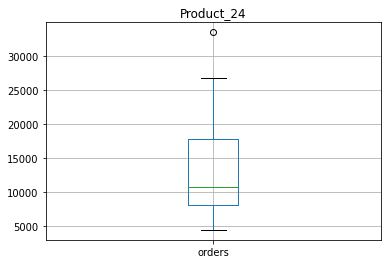

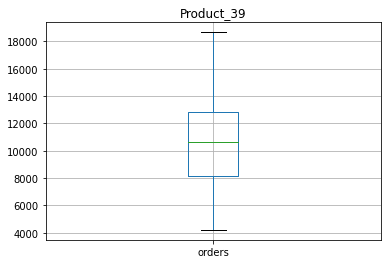

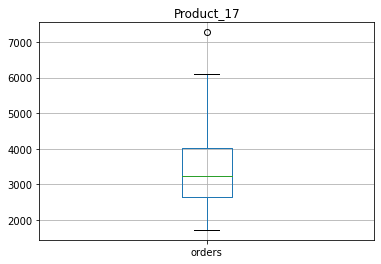

In [64]:
# check for any outliers per sku, sample 3 skus
for sku in df.sample(n=3).sku.unique().tolist():
    boxplot = df[df['sku']==sku]
    boxplot.boxplot()
    plt.title(sku)
    plt.show()

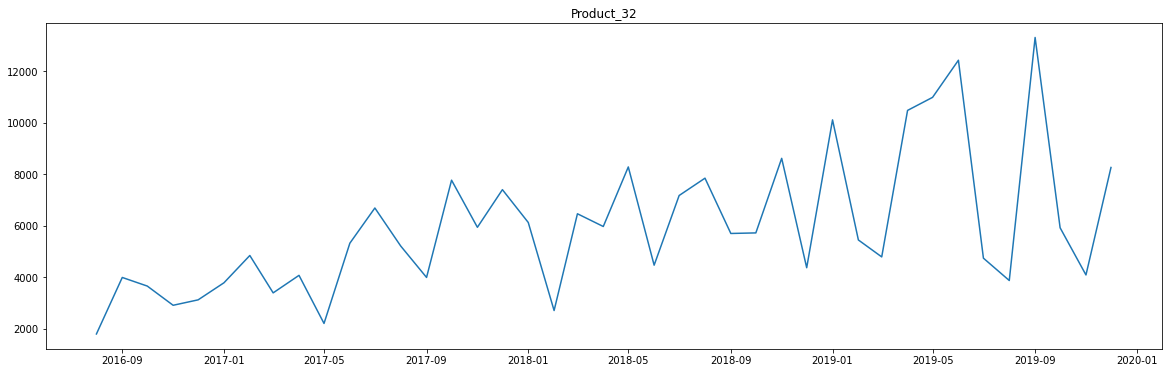

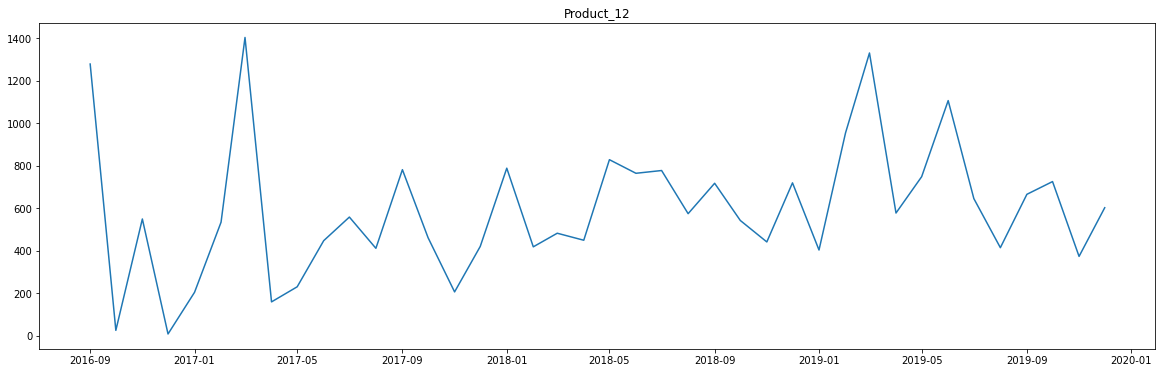

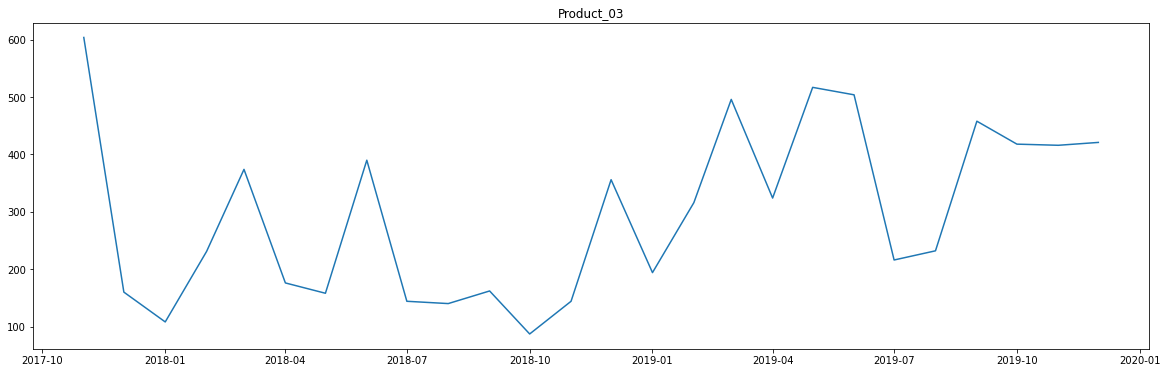

In [34]:
# Plot a sample of 3 sku orders over time
for sku in df.sample(n=3).sku.unique().tolist():
    fig = plt.figure(facecolor = 'white', figsize = (20, 6))
    data = df[df['sku']==sku]
    dates = data.month.tolist()
    orders = data.orders.tolist()
    plt.plot(dates, orders)
    plt.title(sku)
    plt.show()

In [65]:
# any monthly orders of 0?
skus_monthly_order_zero = df[df['orders']==0].groupby('sku').month.count().index.unique().tolist()
# observe any skus where monthly orders is 0
for sku in skus_monthly_order_zero:
    data = df[df['sku']==sku].orders.tolist()
    print(sku, 'monthly orders : ', data)

Product_09 monthly orders :  [205, 30, 0, 6, 3, 4, 4, 0, 1, 0, 4, 2, 3, 582, 1, 1, 11, 114, 37, 77, 148, 146, 165, 76, 145, 222, 221, 4, 110, 130, 205, 112, 97]
Product_14 monthly orders :  [337, 443, 143, 9, 135, 102, 103, 86, 188, 44, 213, 77, 234, 413, 18, 95, 52, 42, 99, 93, 110, 111, 283, 388, 444, 67, 51, 85, 223, 43, 102, 318, 43, 276, 146, 8, 77, 19, 0, 0, 0]
Product_15 monthly orders :  [1915, 2669, 3540, 1935, 1906, 3392, 1874, 2049, 2595, 2540, 2339, 2984, 1798, 1517, 2924, 1579, 1129, 1044, 1385, 1364, 1738, 2012, 1601, 2079, 1278, 2042, 1693, 2535, 1517, 1344, 1658, 1381, 345, 519, 0, 0, 0, 0, 0, 0, 0]
Product_22 monthly orders :  [107, 431, 417, 86, 189, 448, 245, 177, 324, 64, 251, 87, 198, 260, 198, 45, 323, 129, 196, 239, 261, 280, 244, 368, 153, 217, 131, 436, 434, 140, 308, 458, 197, 501, 114, 325, 369, 2, 0, 0, 0]
Product_40 monthly orders :  [4, 0, 0, 0, 106, 3512, 1899, 378, 195, 1072, 564, 1327, 355, 643, 1106, 1785, 1235, 2490, 2075, 805, 782, 1095, 759, 2559, 2

We see that some skus have an outlier at the beginning, some at the end, while other skus trends change over time. Some skus seem to have seasonality, while some do not. It would be useful to use a robust ML model that can predict each sku orders given that there are different trends in each.

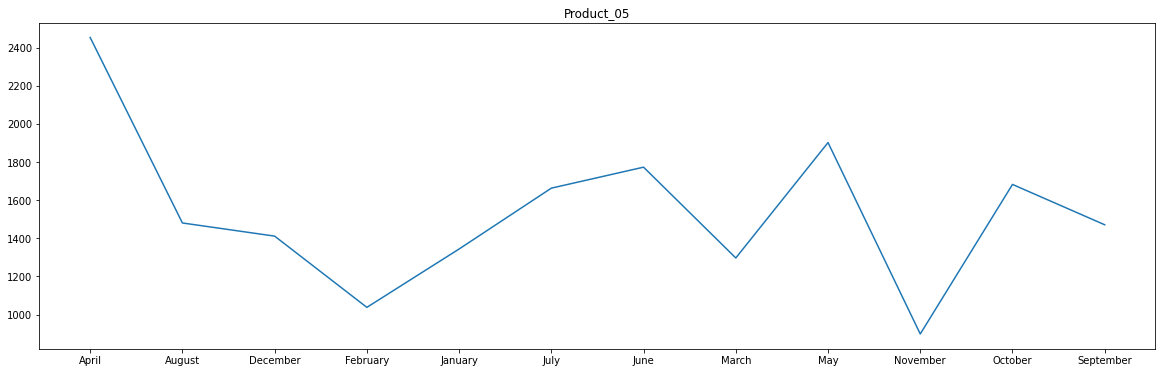

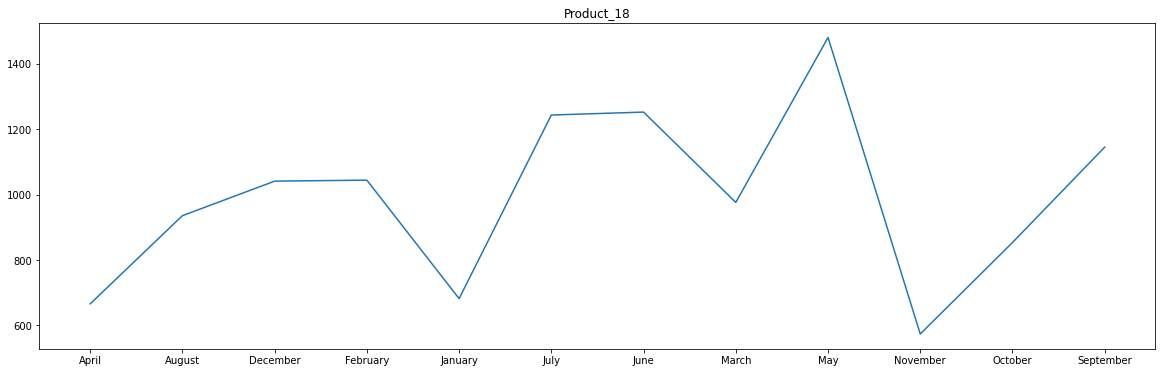

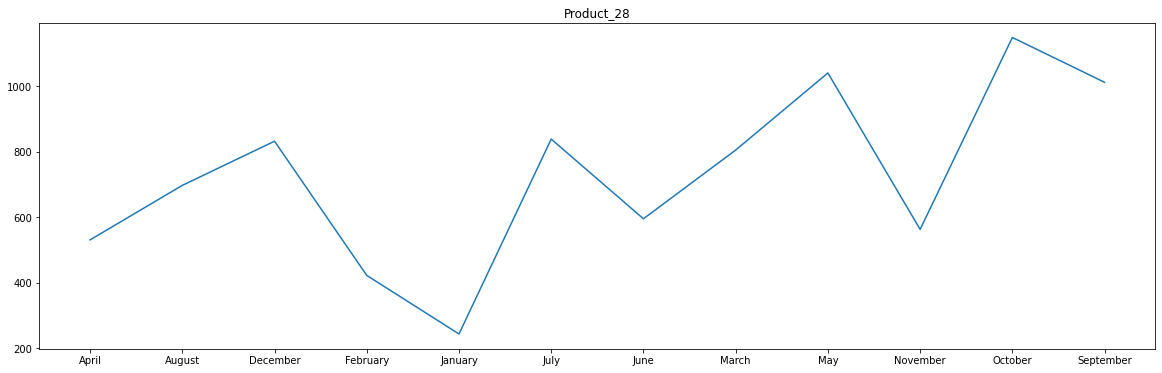

In [75]:
# check which months are the busiest
# Plot a sample of 3 sku orders over time
for sku in df.sample(n=3).sku.unique().tolist():
    fig = plt.figure(facecolor = 'white', figsize = (20, 6))
    data = pd.DataFrame(df[df['sku']==sku].groupby('month_name').orders.median())
    dates = data.index.tolist()
    orders = data.orders.tolist()
    plt.plot(dates, orders)
    plt.title(sku)
    plt.show()